#Generate data

In [61]:
import numpy as np
import random

# returns a matrix with the desired dimensions
def get_matrix(n, m):
    if m == None:
      m==n

    return np.zeros((n, m))


def get_points(n, m):
    # choose 2 points at random for gausion distribution centers
    p1 = (random.randint(0, n-1), random.randint(0, m-1))
    p2 = (random.randint(0, n-1), random.randint(0, m-1))

    while p1[0] == 0 and p1[1] == 0:
       p1 = (random.randint(0, n-1), random.randint(0, m-1))

    # No Duplicates
    while (p1[0] == p2[0] and p1[1] == p2[1]) or (p2[0] == 0 and p2[1] == 0):
      p2 = (random.randint(0, n-1), random.randint(0, m-1))

    return [p1, p2]

def populate_distribution(mat, points):

    #get dims
    n = len(mat)
    m = len(mat[0])

    p1 = points[0]
    p2 = points[1]

    print(p1, p2)

    mat[p1[0]][p1[1]] = 0.5
    mat[p2[0]][p2[1]] = 0.5

    return mat

def define_a_target(mat):
    # choose a target from the 3d distribution

    i = 0
    j = 0

    # pick a random number n 0 to 1
    # traverse the graph summing cells unitl sum > n

    n = random.uniform(0, 1)
    print(n)
    sum = 0

    point = None


    for (index1, i) in enumerate(mat):
      for (index2, j) in  enumerate(i):
        sum+=j
        if (sum > n and point == None):
          point = (index1, index2)

    return point

def get_populated_map(map_dim):
  mat = get_matrix(map_dim, map_dim)
  points = get_points(map_dim, map_dim)
  mat = populate_distribution(mat, points)
  return mat


In [62]:
map_dim = 4
tail_len = 12
start = (0,0)

mat = get_populated_map(map_dim)
print(mat)

target = define_a_target(mat)
print(target)


(0, 1) (1, 1)
[[0.  0.5 0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]
0.7871858264115443
(1, 1)


#Update probability distribution

In [63]:
#params
ed = 0.05   # missed detection
ef = 0.01   # false alarm


# takes in the probability distribution matrix and the current square as arguments
# returns updated matrix
def update_probability_distribution(mat, curr, verbose=0):

  # calculate bi
  bi = ed*mat[curr[0]][curr[1]]+(1-ef)*(1-mat[curr[0]][curr[1]])

  for (row, vec) in enumerate(mat):
    for (col, item) in enumerate(mat[row]):

      if curr[0] == row and curr[1] == col:
        mat[row][col] *= (ed/bi)
      else:
        mat[row][col] *= ((1 - ef)/bi)

  if verbose != 0:
    sum = np.sum(mat)
    if sum != 1:
      print("sum was not 1, sum was: ", sum)
      print(mat)
    else:
      print("good job")
      print(mat)

  return mat



In [64]:
mat2 = update_probability_distribution(mat, (0, 1), 1)
print(mat2)

good job
[[0.         0.04807692 0.         0.        ]
 [0.         0.95192308 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
[[0.         0.04807692 0.         0.        ]
 [0.         0.95192308 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# Reward Policy

Finding the target: + 50

Incentive to win quickly: + 50 - number of moves

Going out of bounds: -50

Timing out: -50

# Prepping For Graphs

In [65]:
game_results=[]
TTW = [] #time to win
TTWMA = []
total_games = 0

wins = 0
oob = 0
timeout = 0

history_wins = []
history_OOB = []
history_timeout = []


win_percentage = []
OOB_percentage = []
timeout_percentage = []

win_window_50 = []
oob_window_50 = []
timeout_window_50 = []

avg_TTW = 0

#Modified Snake Game

In [66]:
import pygame
import random
from enum import Enum
from collections import namedtuple
import numpy as np

pygame.init()
#font = pygame.font.Font('arial.ttf', 25)

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple('Point', 'x, y')

# rgb colors
WHITE = (255, 255, 255)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0,0,0)
GREEN = (50, 200, 50)
YELLOW = []
num = 255
for x in 12:
   YELLOW.append((num, num, 0))
   num -= 20

BLOCK_SIZE = 25
BORDER_SIZE = 10
MINI_BLOCK_SIZE = BLOCK_SIZE - BORDER_SIZE

SCALER = 5

BLOCK_SIZE = BLOCK_SIZE*SCALER
BORDER_SIZE = BORDER_SIZE*SCALER/2
MINI_BLOCK_SIZE = MINI_BLOCK_SIZE*SCALER

SPEED = 40

WIDTH = BLOCK_SIZE * map_dim
HEIGHT = BLOCK_SIZE * map_dim

ed = 0.05   # missed detection
ef = 0.01   # false alarm

class SnakeGameAI:

    def __init__(self):
        self.w = WIDTH
        self.h = HEIGHT
        # init display
        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption('Drone')
        self.clock = pygame.time.Clock()
        self.reset()


    def reset(self):
        self.drone = Point(0, 0)
        self.drone_map = (0, 0)
        self.score = 0
        self.target = None
        self.target_map = None
        self.map = self._gen_map()
        self._place_target()
        self.frame_iteration = 0
        self.map2=np.copy(self.map)
        self.map2[self.target_map[0]][self.target_map[1]] = 8
        self.tail = []
        self.tail_max_len = tail_len


    def _place_target(self):
        # choose a target from the 3d distribution
        i = 0
        j = 0

        # pick a random number n between 0 to 1
        # traverse the graph summing cells until sum > n
        n = random.uniform(0, 1)
        print(n)
        sum = 0;
        point = None;
        for (index1, i) in enumerate(self.map):
          for (index2, j) in  enumerate(i):
            sum += j
            if (sum > n and point == None):
              point = (index1, index2)

        self.target_map = point
        self.target = Point(point[0]*BLOCK_SIZE, point[1]*BLOCK_SIZE)
        return
    
    def prepare_data_for_graphs(self):
        global oob
        global wins
        global timeout
        global total_games

        total_games+=1
        history_wins.append(wins)
        history_OOB.append(oob)
        history_timeout.append(timeout)

        OOB_percentage.append(oob/total_games)
        win_percentage.append(wins/total_games)
        timeout_percentage.append(timeout/total_games)
        
        if len(game_results) > 50:
            rec50 = game_results[-50:]
            num_wins = rec50.count(2)
            num_oob = rec50.count(1)
            num_timeout = rec50.count(3)
            win_window_50.append(num_wins/50)
            oob_window_50.append(num_oob/50)
            timeout_window_50.append(num_timeout/50)
        else: 
            leng = len(game_results)
            num_wins = game_results.count(2)
            num_oob = game_results.count(1)
            num_timeout = game_results.count(3)
            win_window_50.append(num_wins/leng)
            oob_window_50.append(num_oob/leng)
            timeout_window_50.append(num_timeout/leng)
        return
    
    def prepare_TTW_graph(self):
        TTW.append(self.frame_iteration)
        if len(TTW) >= 30:
            res = TTW[-30:]
            TTWMA.append(np.average(res))
        else:
            TTWMA.append(np.average(TTW))
        return    

    def play_step(self, action):
        self.frame_iteration += 1
        self.score += 1
        reward = -10
        game_over = False

        # 1. collect user input
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()


        # 2. move
        self._move(action) # update the drone location
        global oob
        global wins
        global timeout

        #3. check if out of bounds
        if self.is_collision():
            print("OOB")
            game_over = True
            reward = -300
            game_results.append(1)
            oob += 1

            self.prepare_data_for_graphs()

            return reward, game_over, self.score


        # 4. check if target found
        if self.drone_map[0] == self.target_map[0] and self.drone_map[1] == self.target_map[1]:
            print("WIN")
            game_over = True
            reward = 600 - (6 * self.frame_iteration)
            game_results.append(2)
            wins+=1
            
            self.prepare_data_for_graphs()
            self.prepare_TTW_graph()

            return reward, game_over, self.score

        # 5. To prevent the agent from going in circles and never ending
        #    limit game to 100 moves
        if self.frame_iteration == 100:
            print("TO")
            game_over = True
            reward = 0-3*(self.frame_iteration)
            game_results.append(3)
            timeout += 1

            self.prepare_data_for_graphs()
          
            return reward, game_over, self.score


        # 6. Check if stepping on tail
        if self.drone_map[0] == self.tail[0][0] and self.drone_map[1] == self.tail[0][1]:
           print("Stepped on Tail")
           reward -= 20
        if self.drone_map[0] == self.tail[1][0] and self.drone_map[1] == self.tail[1][1]:
           print("Stepped on Tail")
           reward -= 20
        if self.drone_map[0] == self.tail[2][0] and self.drone_map[1] == self.tail[2][1]:
           print("Stepped on Tail")
           reward -= 20

        # 7. reward for checking a high probability space
        reward += self.map[self.drone_map[0]][self.drone_map[1]]*100

        print('reward = ', reward)

        # 8. update ui and clock and map
        self._update_probability_dist()
        self._update_ui()
        self.clock.tick(SPEED)


        # 9. return game over and score
        return reward, game_over, self.score


    def is_collision(self, pt=None):
        if pt is None:
            pt = self.drone
        # hits boundary
        if pt.x > self.w - BLOCK_SIZE or pt.x < 0 or pt.y > self.h - BLOCK_SIZE or pt.y < 0:
            return True
        return False


    def _update_ui(self):
        # fill the background with black
        self.display.fill(BLACK)

        # draw all non zero probability spaces
        spaces = []
        for (row, vec) in enumerate(self.map):
          for (col, item) in enumerate(self.map[row]):
            if self.map[row][col] != 0:
              spaces.append((row, col, self.map[row][col]))

        print(spaces, self.drone_map, self.target_map)
        for pt in spaces:
          RED = (int(round((pt[2]*200+55))), 0, 0)
          pygame.draw.rect(self.display, RED, pygame.Rect(pt[1]*BLOCK_SIZE, pt[0]*BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))

        # draw the target
        pygame.draw.rect(self.display, GREEN, pygame.Rect(self.target.y+BORDER_SIZE, self.target.x+BORDER_SIZE, MINI_BLOCK_SIZE, MINI_BLOCK_SIZE))

        # draw the tail
        for i, pt in enumerate(self.tail):
          pygame.draw.rect(self.display, YELLOW[i], pygame.Rect(pt[1]*BLOCK_SIZE+BORDER_SIZE, pt[0]*BLOCK_SIZE+BORDER_SIZE, MINI_BLOCK_SIZE, MINI_BLOCK_SIZE))

        # draw the droan
        #pygame.draw.rect(self.display, BLUE1, pygame.Rect(self.drone.x, self.drone.y, BLOCK_SIZE, BLOCK_SIZE))
        pygame.draw.rect(self.display, BLUE2, pygame.Rect(self.drone.x+BORDER_SIZE, self.drone.y+BORDER_SIZE, MINI_BLOCK_SIZE, MINI_BLOCK_SIZE))

        # text = font.render("Score: " + str(self.score), True, WHITE)
        # self.display.blit(text, [0, 0])
        pygame.display.flip()


    def _update_probability_dist(self):
        curr = self.drone_map
        bi = ed*self.map[curr[0]][curr[1]]+(1-ef)*(1-self.map[curr[0]][curr[1]])

        for (row, vec) in enumerate(self.map):
          for (col, item) in enumerate(self.map[row]):
            if curr[0] == row and curr[1] == col:
              self.map[row][col] *= (ed/bi)
            else:
              self.map[row][col] *= ((1 - ef)/bi)

    def _move(self, action):

        # add to tail
        self.tail.append(self.drone_map)
        if len(self.tail) >= self.tail_max_len:
            self.tail.pop(0)

        # transform coordinates
        x = self.drone.x
        y = self.drone.y
        col = self.drone_map[1]
        row = self.drone_map[0]

        # move the points
        if np.array_equal(action, [1, 0, 0, 0]):
            x += BLOCK_SIZE
            col += 1
            print("right")
        elif np.array_equal(action, [0, 1, 0, 0]):
            x -= BLOCK_SIZE
            col -= 1
            print("left")
        elif np.array_equal(action, [0, 0, 1, 0]):
            y += BLOCK_SIZE
            row += 1
            print("down")
        elif np.array_equal(action, [0, 0, 0, 1]):
            y -= BLOCK_SIZE
            row -= 1
            print("up")
        else: # [0, 0, 0, 0, 1]
            print("STAY")

        # update the coordinataes
        self.drone = Point(x, y)
        self.drone_map = (row, col)

        return


    def _gen_map(self):
        mat = get_matrix(map_dim, map_dim)
        points = get_points(map_dim, map_dim)
        mat = populate_distribution(mat, points)
        return mat


# PyTorch model

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)


class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        # (n, x)

        if len(state.shape) == 1:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)

        targ = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            targ[idx][torch.argmax(action[idx]).item()] = Q_new

        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()
        loss = self.criterion(targ, pred)
        loss.backward()

        self.optimizer.step()

# plotting functions

In [68]:
import matplotlib.pyplot as plt
from IPython import display

def tuple2onehot(tuple):
    onehot_x = [0, 0, 0, 0]
    onehot_y = [0, 0, 0, 0]
    if tuple[1] >= 0 and tuple[1] < 4:
        onehot_x[tuple[1]] = 1
    if tuple[0] >= 0 and tuple[0] < 4:
        onehot_y[tuple[0]] = 1
    return onehot_x, onehot_y


# Agent

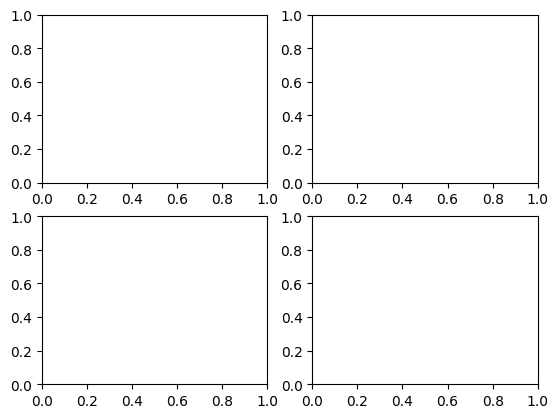

KeyboardInterrupt: 

In [69]:
import torch
import random
import numpy as np
from collections import deque

MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.02

input_dim = map_dim*map_dim + 8 + 8*tail_len
hidden_dim = 1024 # we'll just try this I guess
output_dim = 4 # up, down, right, left

class Agent:

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.99 # discount rate
        self.memory = deque(maxlen = MAX_MEMORY) # popleft()
        self.model = Linear_QNet(input_dim, hidden_dim, output_dim)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)


    def get_state(self, game):
        drone = game.drone_map
        tail = game.tail
        drone_x, drone_y = tuple2onehot(drone)
        for pt in tail:
            tail_x, tail_y = tuple2onehot(tail[0])
            state = np.append(np.array(state).flatten(), tail_x)
            state = np.append(np.array(state).flatten(), tail_y)

        for pt in tail:
        state = np.append(np.array(state).flatten(), [0, 0, 0, 0])
        state = np.append(np.array(state).flatten(), tail2_y)
        state = np.append(np.array(state).flatten(), tail3_x)
        state = np.append(np.array(state).flatten(), tail3_y)
        return np.array(state)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
        # for state, action, reward, nexrt_state, done in mini_sample:
        #    self.trainer.train_step(state, action, reward, next_state, done)

    def train_short_memory(self, state, action, reward, next_state, done):
        #print(type(state), type(action), type(reward), type(next_state) )
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 100 - (self.n_games/5)
        final_move = [0, 0, 0, 0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 3)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move


def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = SnakeGameAI()
    while True:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            # train long memory, plot result
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            print('Game', agent.n_games, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            fig, ax = plt.subplots(2, 2)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            ax[0, 0].plot(history_wins, label='wins')
            ax[0, 0].plot(history_OOB, label='oob')
            ax[0, 0].plot(history_timeout, label='timeout')
            ax[0, 1].plot(win_percentage, label='wins')
            ax[0, 1].plot(OOB_percentage, label='oob')
            ax[0, 1].plot(timeout_percentage, label='timeout')
            ax[1, 0].plot(TTW, label='wins')
            ax[1, 0].plot(TTWMA, label='oob')
            ax[1, 1].plot(win_window_50, label='wins')
            ax[1, 1].plot(oob_window_50, label='oob')
            ax[1, 1].plot(timeout_window_50, label='timeout')
            plt.figure(figsize=(15,15))
            plt.show()



if __name__ == '__main__':
    train()

In [ ]:
print(TTWMA[len(TTWMA)-1])
      

7.366666666666666


homework 9
quantization

In [ ]:
import numpy as np

# original matrix
om = [[2.10, 0.05, -0.98, -2.0],
     [1.10, -0.2, 0.000, 0.70],
     [0.00, -1.7, 2.300, 1.00],
     [-1.0, 0.50, 3.000, -0.6]]

# quantized matrix
qm = [[ 4, -2, -5, -8],
      [ 1, -3, -2, 0],
      [-2, -7,  5, -8],
      [ -5, -1,  7, -4]]

# reconstructed matrix
rm = (np.asarray(qm) + 2 ) * 0.33333333333
print(rm)
print()


# quantization error
qe = rm - om
print(qe)